- 라이브러리 불러오기

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import xgboost
import lightgbm
import warnings
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, XGBRFClassifier
warnings.filterwarnings('ignore')

- 데이터 확인

In [11]:
df = pd.read_csv(r'/content/drive/MyDrive/Kamp/경진대회용 주조 공정최적화 데이터셋.csv', encoding='euc-kr')
df = df.drop('Unnamed: 0',axis=1)

In [12]:
num_pass = len(df[df['passorfail']==0])
num_fail = len(df[df['passorfail']==1])

print(f'pass : {num_pass}')
print(f'fail : {num_fail}')
print(f'불량률 : {num_fail/(num_pass+num_fail)*100} %')

pass : 87998
fail : 4016
불량률 : 4.364553220162149 %


In [13]:
df.columns, len(df.columns)

(Index(['line', 'name', 'mold_name', 'time', 'date', 'count', 'working',
        'emergency_stop', 'molten_temp', 'facility_operation_cycleTime',
        'production_cycletime', 'low_section_speed', 'high_section_speed',
        'molten_volume', 'cast_pressure', 'biscuit_thickness',
        'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
        'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
        'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
        'EMS_operation_time', 'registration_time', 'passorfail',
        'tryshot_signal', 'mold_code', 'heating_furnace'],
       dtype='object'),
 31)

<Axes: >

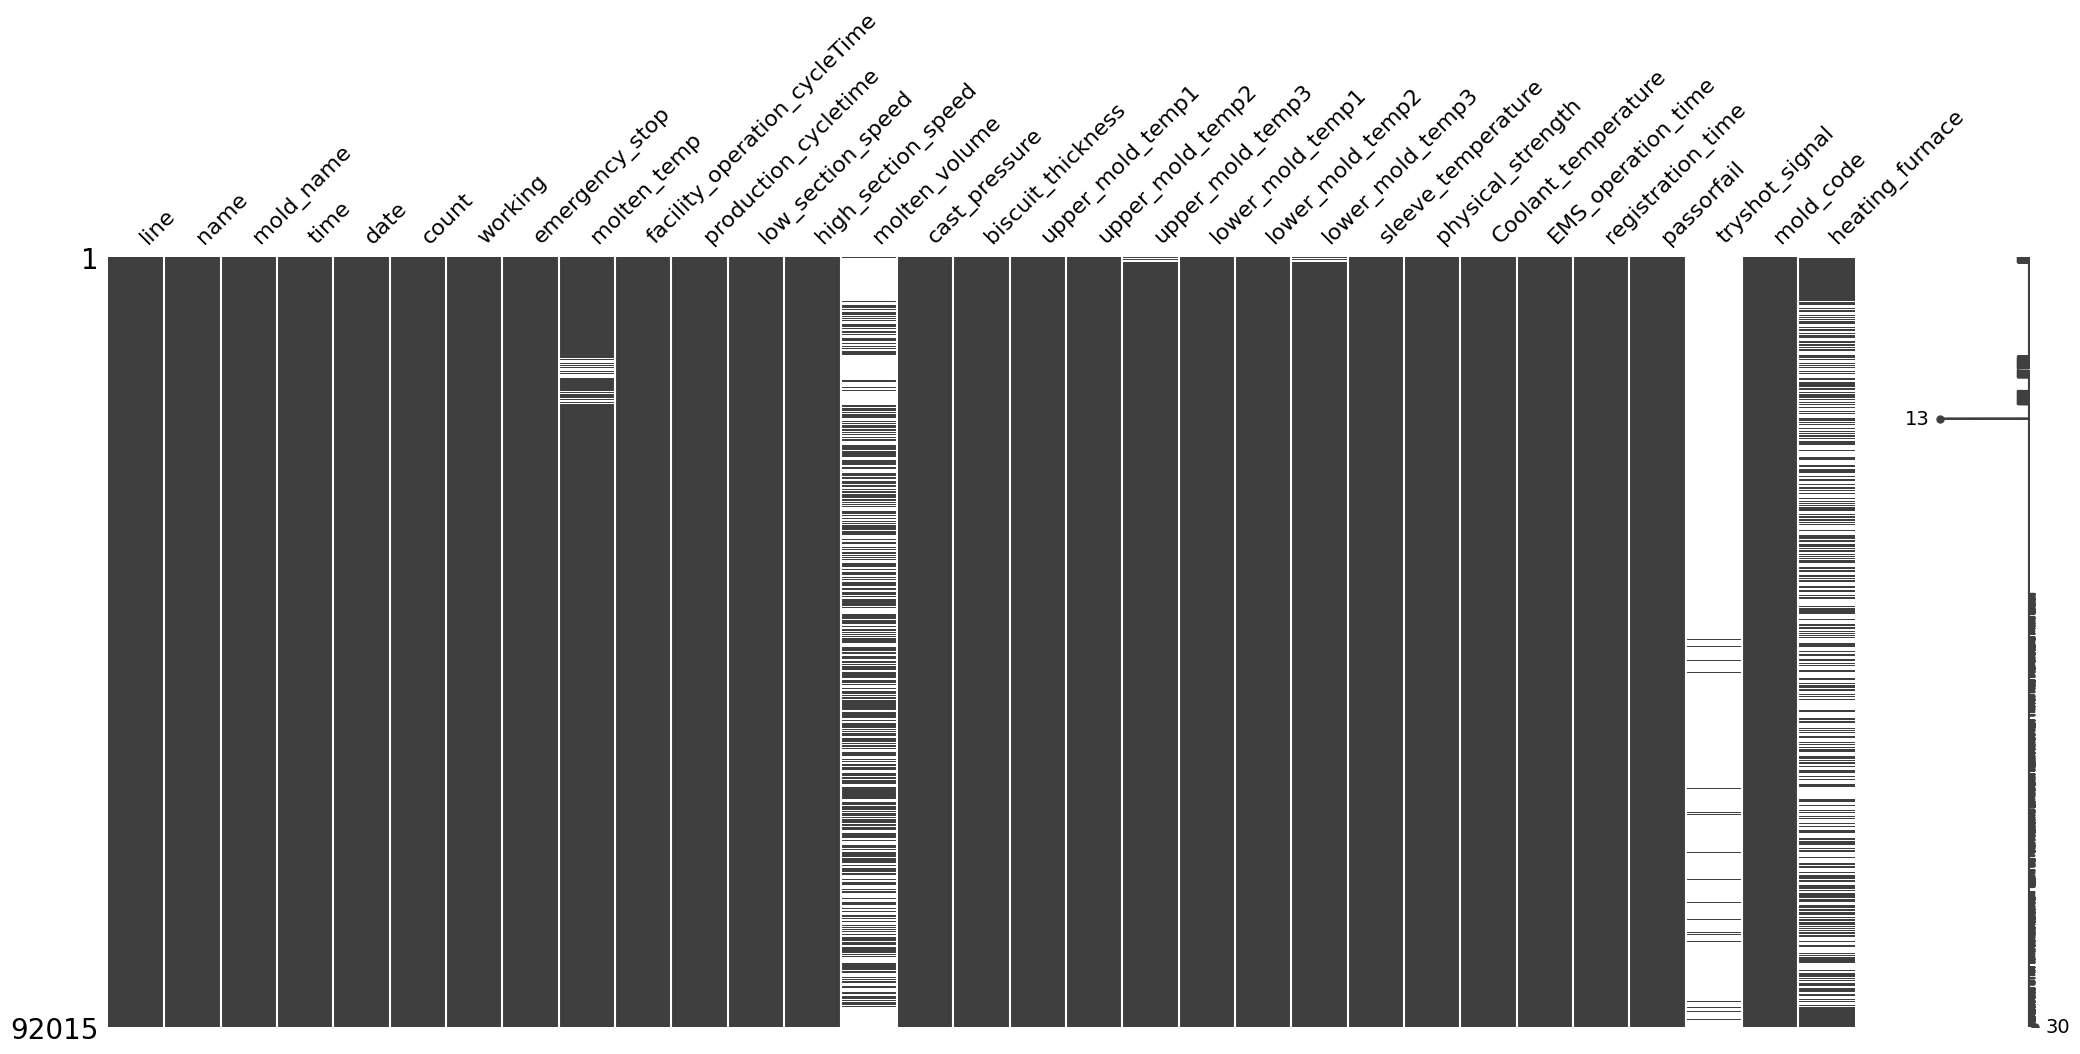

In [14]:
msno.matrix(df)

In [15]:
# 필요없는 컬럼 제거
df = df.drop(columns=['line'])
df = df.drop(columns=['name'])
df = df.drop(columns=['mold_name'])
df = df.drop(columns=['time'])
df = df.drop(columns=['date'])
df = df.drop(columns=['emergency_stop'])
df = df.drop(columns=['molten_volume'])
df = df.drop(columns=['registration_time'])
df = df.dropna(subset=['passorfail'])


# 결측치 채우기
df['tryshot_signal'] = df['tryshot_signal'].fillna('No')   # 과적합으로 인해 컬럼제거 고려 필요
df['heating_furnace'] = df['heating_furnace'].fillna('C')

# 카테고리별 최빈값으로 결측치를 채우기
df['upper_mold_temp3'] = df.groupby('mold_code')['upper_mold_temp3'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))
df['lower_mold_temp3'] = df.groupby('mold_code')['lower_mold_temp3'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))
df['molten_temp'] = df.groupby('mold_code')['molten_temp'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))

df = df.reset_index(drop=True)
df


,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,...,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,258,가동,731.0,119,120,110.0,112.0,331.0,35.0,198.0,...,316.0,1449.0,550.0,700.0,34.0,23,0.0,No,8722,C
1,243,가동,720.0,98,125,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,No,8412,B
2,244,가동,721.0,98,122,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,No,8412,B
3,245,가동,721.0,100,125,112.0,109.0,308.0,49.0,268.0,...,179.0,1449.0,483.0,0.0,30.0,25,0.0,No,8412,B
4,246,가동,721.0,99,123,109.0,110.0,309.0,49.0,276.0,...,187.0,1449.0,486.0,0.0,30.0,25,0.0,No,8412,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,71,가동,731.0,122,122,100.0,101.0,331.0,49.0,83.0,...,201.0,1449.0,279.0,726.0,30.0,0,0.0,No,8917,A
92010,72,가동,731.0,120,121,100.0,101.0,331.0,54.0,83.0,...,201.0,1449.0,279.0,732.0,30.0,0,0.0,No,8917,A
92011,73,가동,732.0,122,135,100.0,101.0,331.0,52.0,79.0,...,195.0,1449.0,272.0,731.0,30.0,0,0.0,No,8917,A
92012,74,가동,732.0,133,122,100.0,101.0,331.0,53.0,82.0,...,199.0,1449.0,288.0,723.0,30.0,0,0.0,No,8917,A


<Axes: >

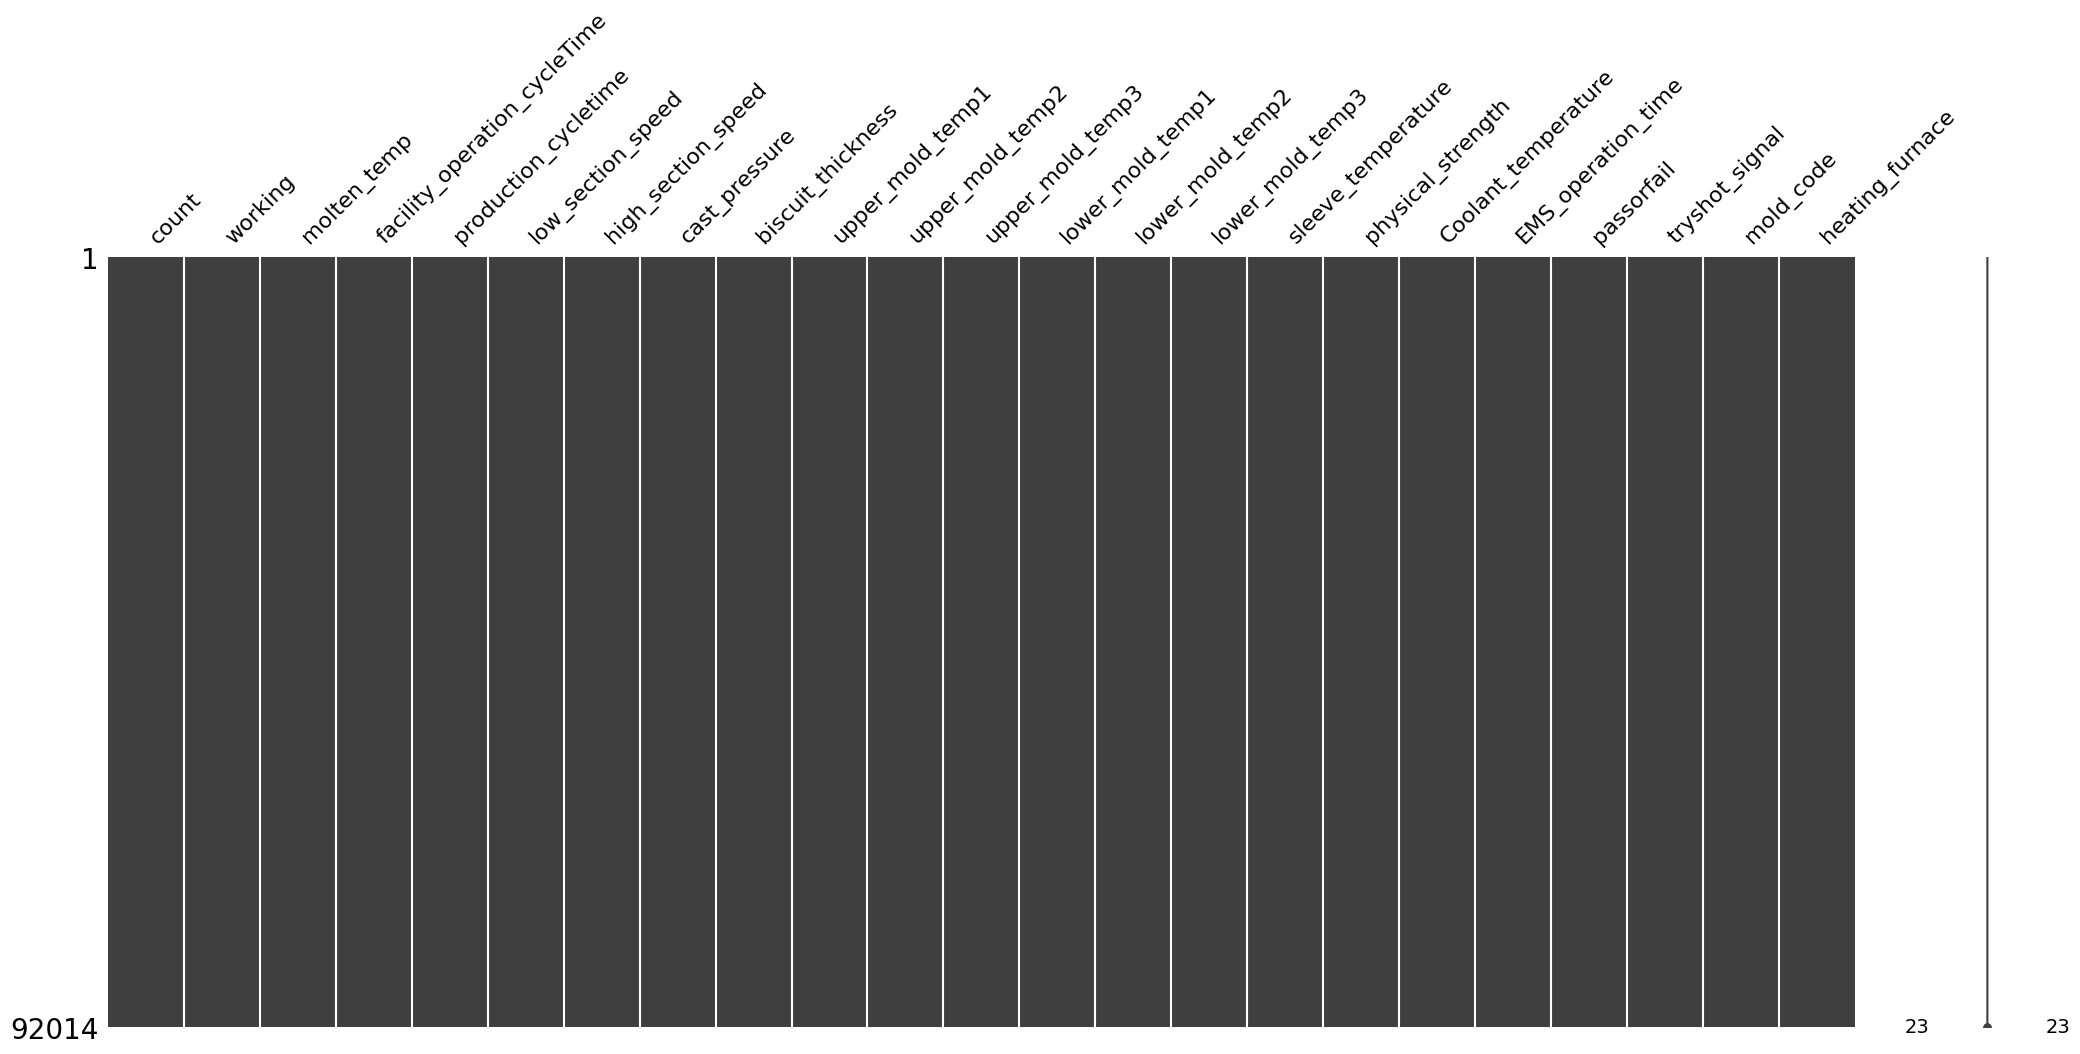

In [16]:
msno.matrix(df)

In [17]:
# 인코딩 진행

# 'working' 컬럼 인코딩
df['working'] = df['working'].replace({'가동': 1, '정지': 0})

# 'tryshot_signal' 컬럼 인코딩
df['tryshot_signal'] = df['tryshot_signal'].replace({'D': 1, 'No': 0})

# 'heating_furnace' 컬럼 인코딩
df['heating_furnace'] = df['heating_furnace'].replace({'A': 0, 'B': 1, 'C': 2})

# 'mold_code' 컬럼 인코딩
df['mold_code'] = df['mold_code'].replace({8412: 0, 8413: 1, 8573: 2, 8576: 3,
                                           8600: 4, 8722: 5, 8917: 6})

In [18]:
# 통계량 확인
df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,92014.0,148.509455,87.969347,1.0,72.0,146.0,222.0,334.0
working,92014.0,0.999446,0.023536,0.0,1.0,1.0,1.0,1.0
molten_temp,92014.0,718.922718,51.125384,0.0,713.0,728.0,731.0,735.0
facility_operation_cycleTime,92014.0,121.556328,12.109582,69.0,117.0,119.0,122.0,457.0
production_cycletime,92014.0,122.515856,13.589387,0.0,119.0,121.0,123.0,485.0
low_section_speed,92014.0,110.794999,305.181962,0.0,110.0,110.0,110.0,65535.0
high_section_speed,92014.0,112.624959,10.759272,0.0,112.0,112.0,112.0,388.0
cast_pressure,92014.0,324.554535,27.327683,41.0,329.0,330.0,331.0,348.0
biscuit_thickness,92014.0,50.666486,17.925620,0.0,47.0,50.0,53.0,422.0
upper_mold_temp1,92014.0,186.208870,46.041322,18.0,163.0,194.0,222.0,1449.0


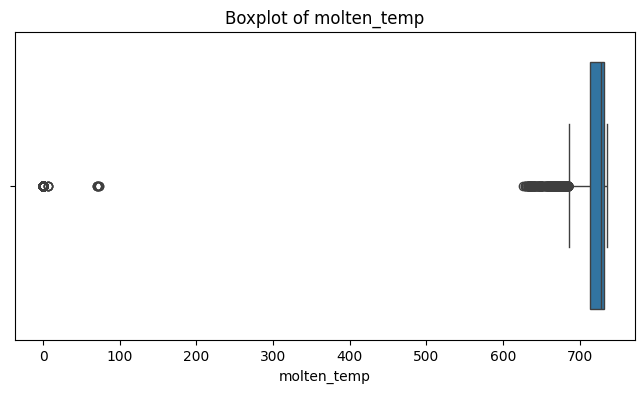

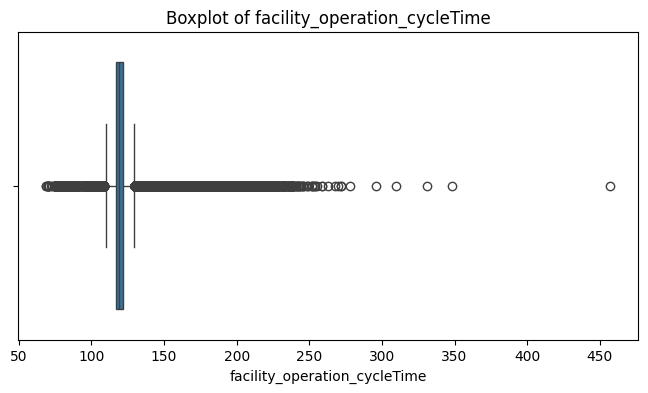

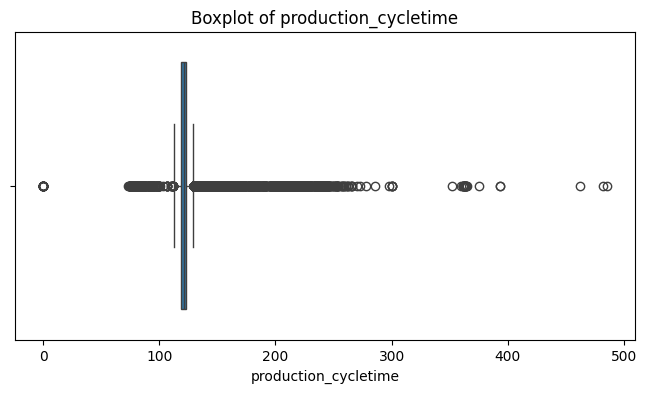

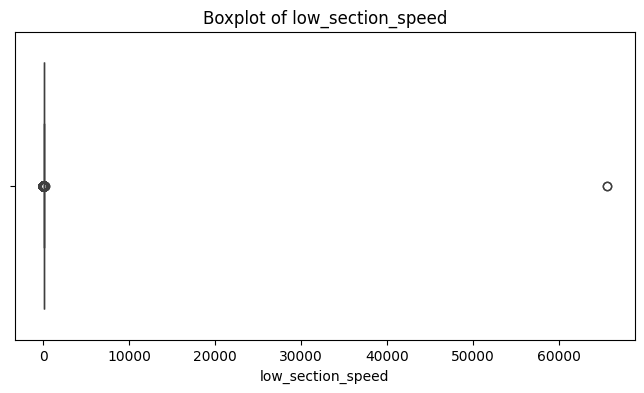

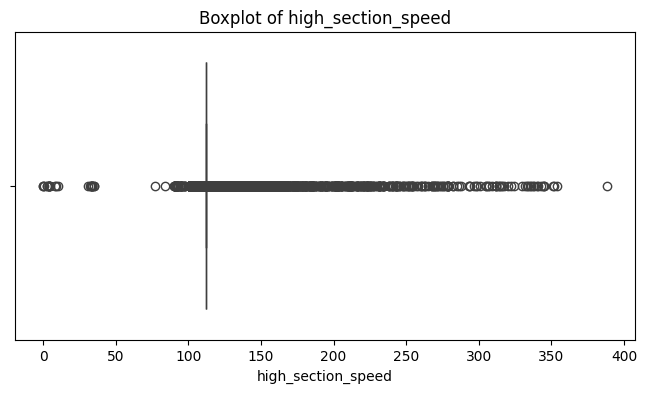

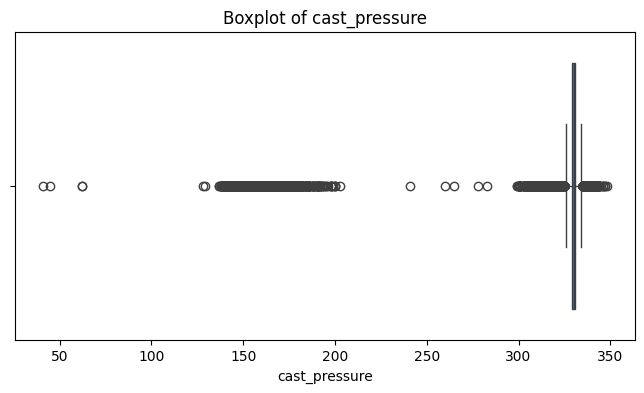

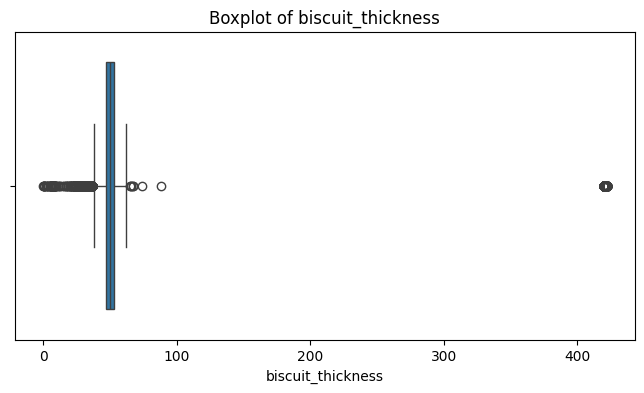

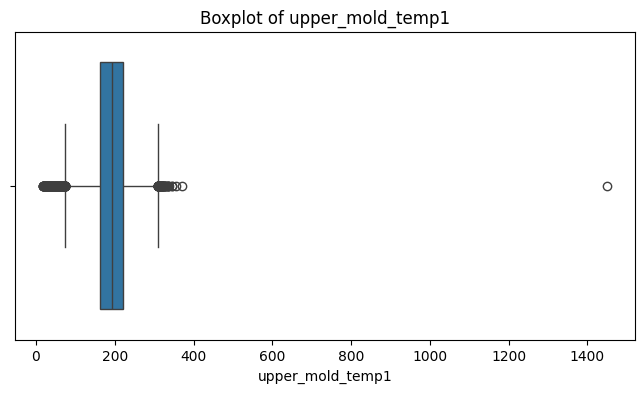

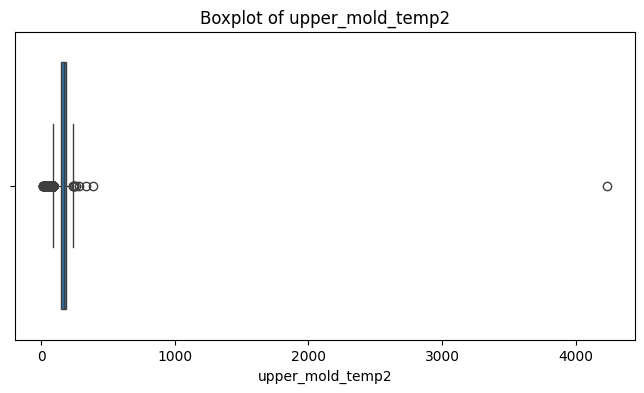

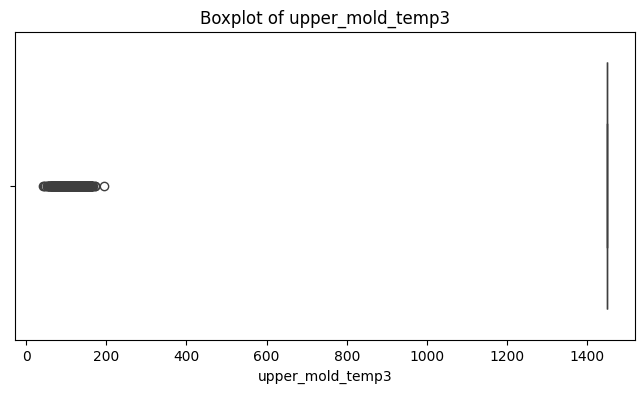

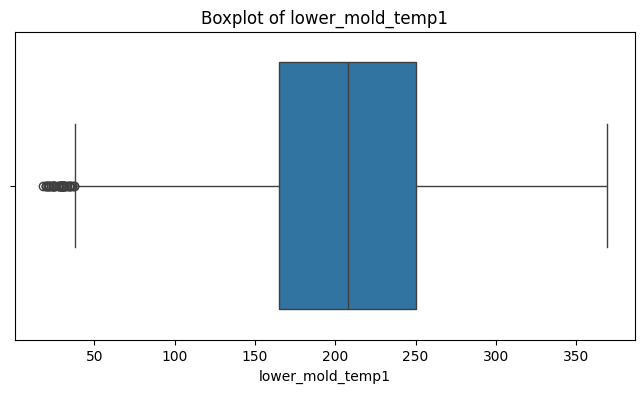

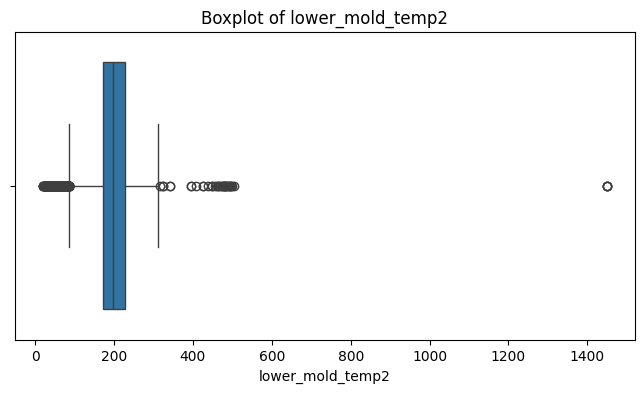

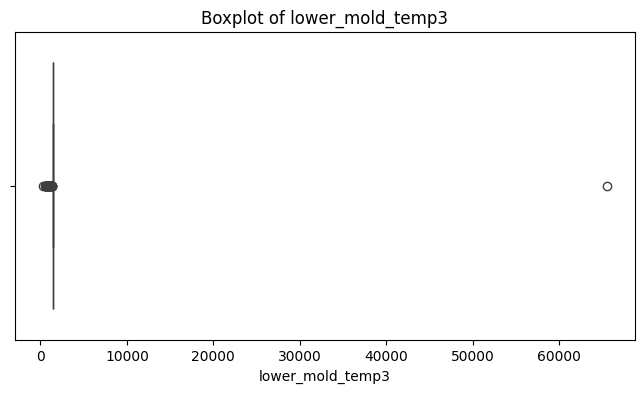

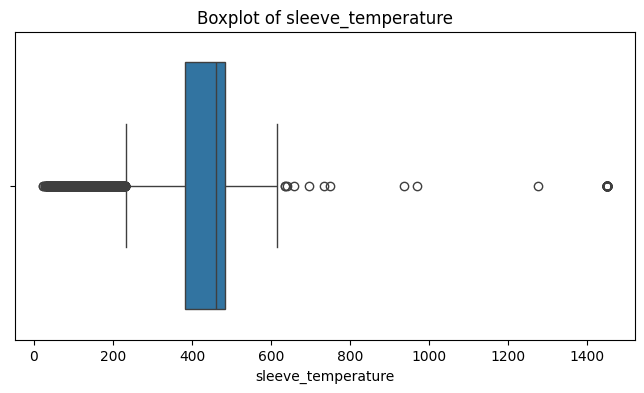

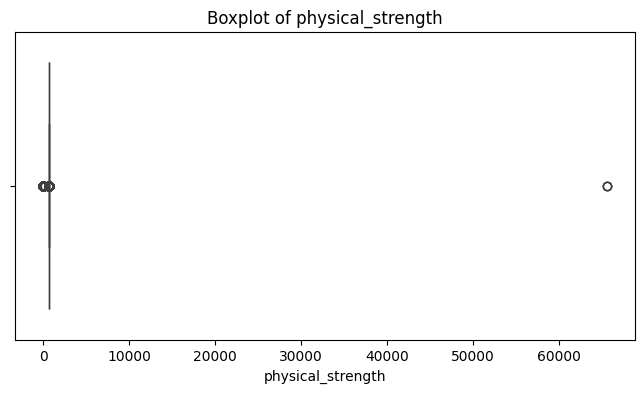

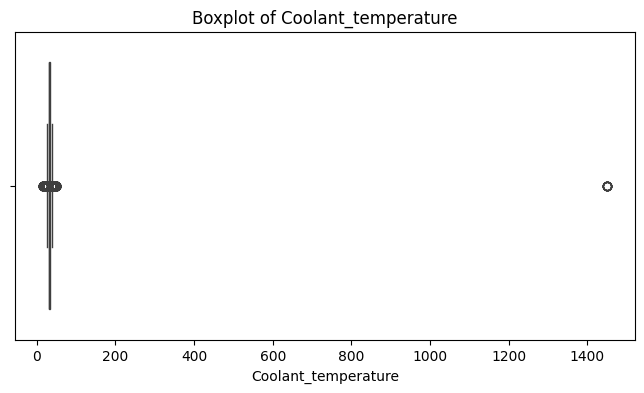

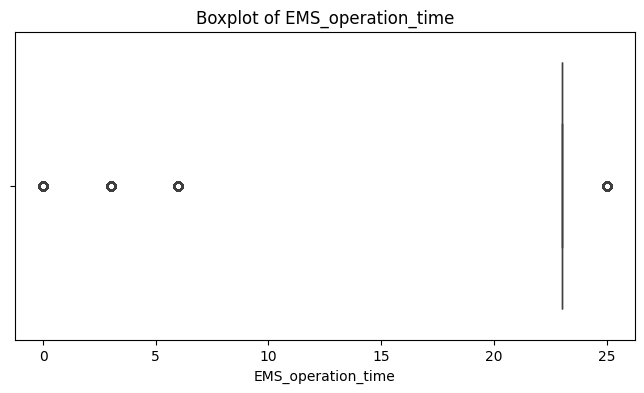

In [19]:
# 인코딩 후 데이터의 이상치를 확인. 이때 인코딩 전 수치형 데이터(데이터의 특성을 고려하여)에 대해서만 확인을 진행한다.
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['molten_temp','facility_operation_cycleTime',
       'production_cycletime', 'low_section_speed', 'high_section_speed',
       'cast_pressure', 'biscuit_thickness', 'upper_mold_temp1',
       'upper_mold_temp2', 'upper_mold_temp3', 'lower_mold_temp1',
       'lower_mold_temp2', 'lower_mold_temp3', 'sleeve_temperature',
       'physical_strength', 'Coolant_temperature', 'EMS_operation_time', ]
# 데이터프레임이 df라고 가정
for column in columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot of {column}')
    plt.show()

이상치 제거  
LOF 방법을 이용해서 제거


In [20]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

df_no_outliers = df.copy()

for column in columns:
    # LOF 모델 생성
    lof = LocalOutlierFactor(n_neighbors=10)

    # 이상치 탐지
    y_pred = lof.fit_predict(df_no_outliers[[column]])

    # -1은 이상치, 1은 정상 데이터
    df_no_outliers['outlier'] = y_pred

    # 이상치 제거
    df_no_outliers = df_no_outliers[df_no_outliers['outlier'] == 1].reset_index(drop=True)

    # outlier 컬럼 제거 (선택 사항)
    df_no_outliers = df_no_outliers.drop(columns=['outlier'])

df_no_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
count,90817.0,148.999791,87.783409,1.0,73.0,147.0,223.0,334.0
working,90817.0,0.999681,0.017867,0.0,1.0,1.0,1.0,1.0
molten_temp,90817.0,719.070493,50.162715,0.0,713.0,728.0,731.0,735.0
facility_operation_cycleTime,90817.0,121.478721,11.677429,69.0,117.0,119.0,122.0,263.0
production_cycletime,90817.0,122.398306,12.826269,0.0,119.0,121.0,123.0,365.0
low_section_speed,90817.0,109.491329,9.295890,0.0,110.0,110.0,110.0,140.0
high_section_speed,90817.0,112.558442,10.366178,0.0,112.0,112.0,112.0,354.0
cast_pressure,90817.0,325.104815,25.633868,139.0,329.0,330.0,331.0,345.0
biscuit_thickness,90817.0,50.466785,15.405684,0.0,47.0,50.0,53.0,422.0
upper_mold_temp1,90817.0,186.781946,45.262590,21.0,164.0,194.0,222.0,337.0


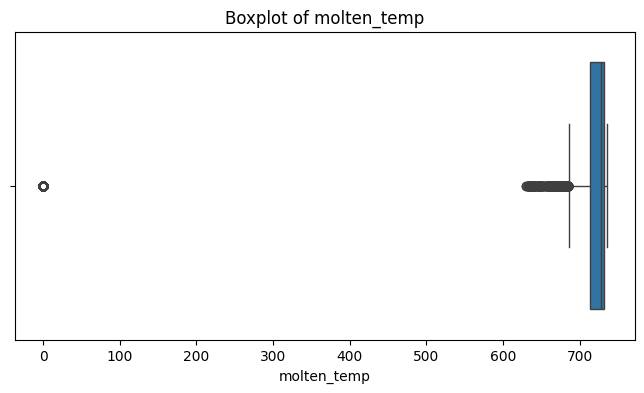

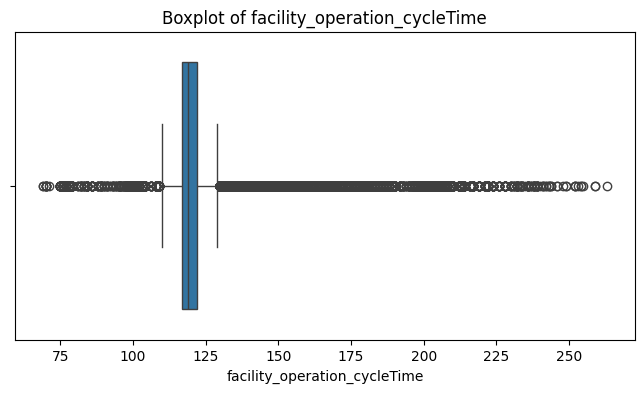

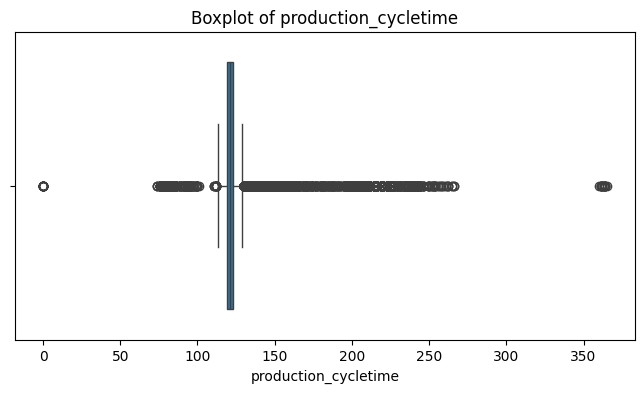

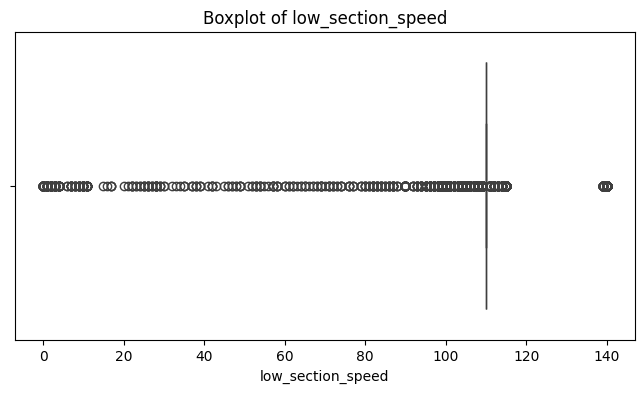

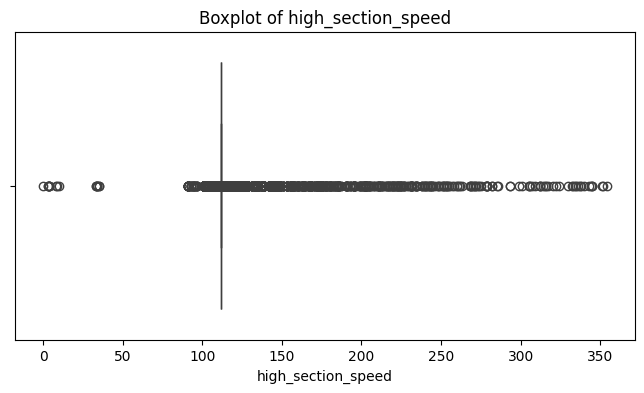

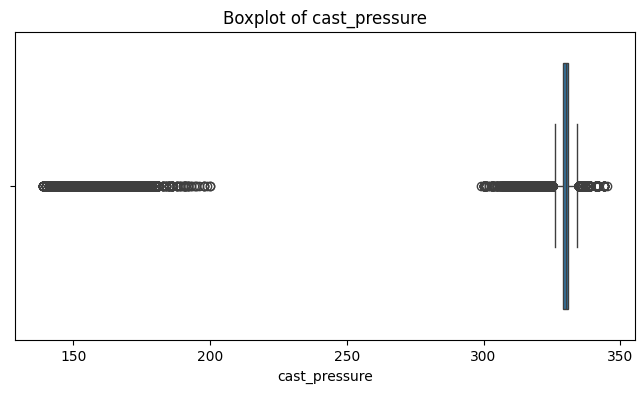

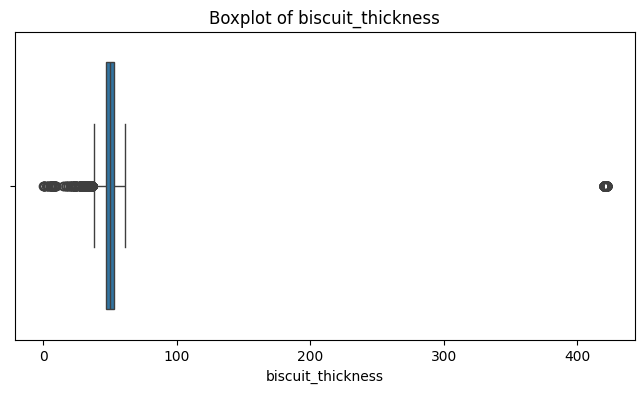

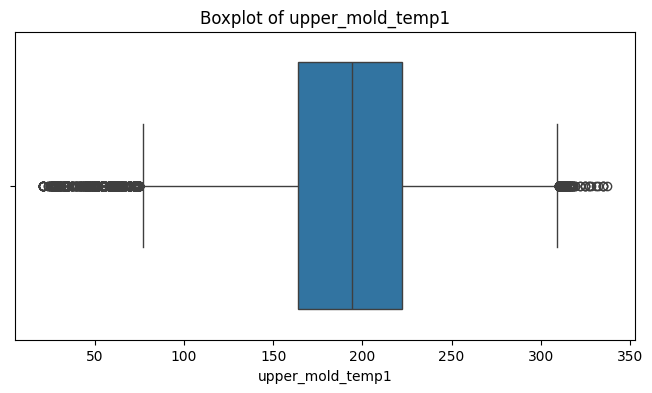

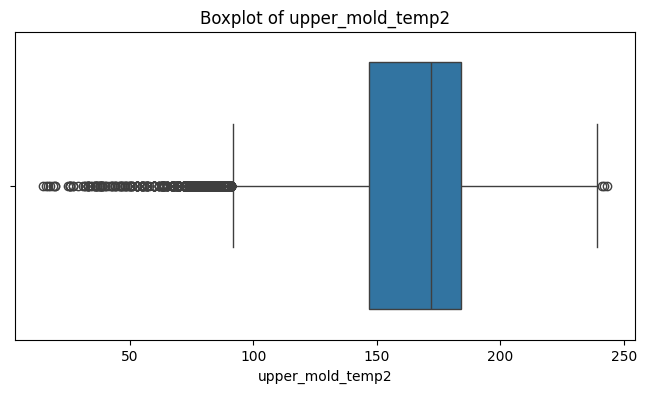

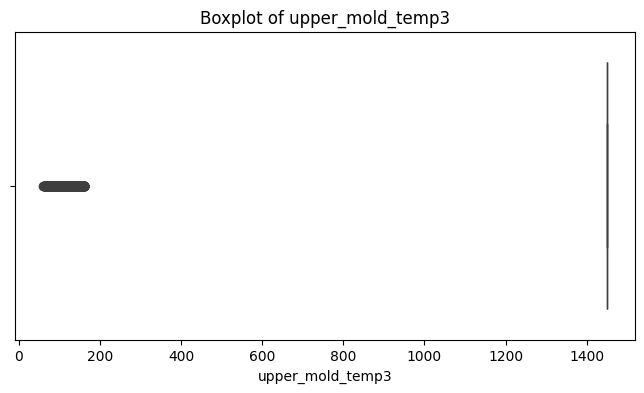

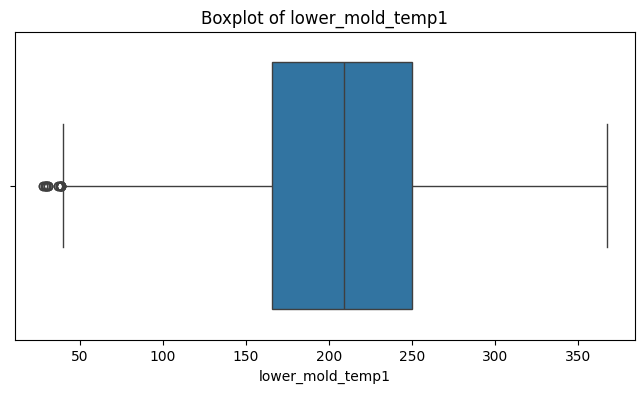

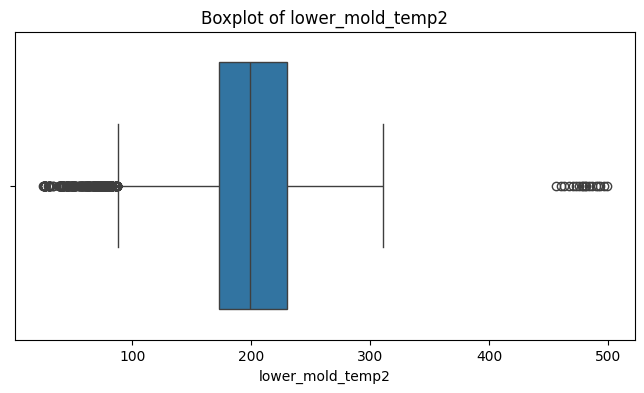

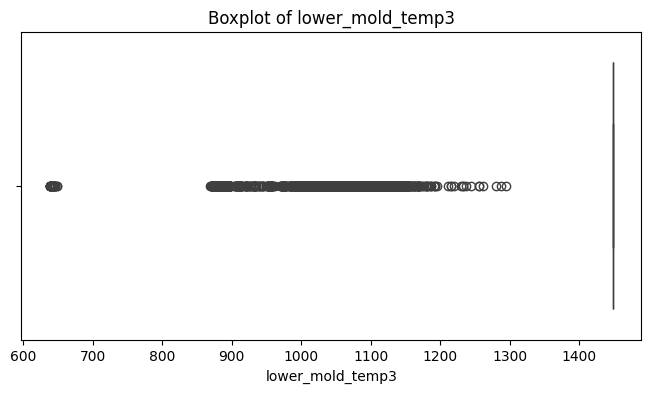

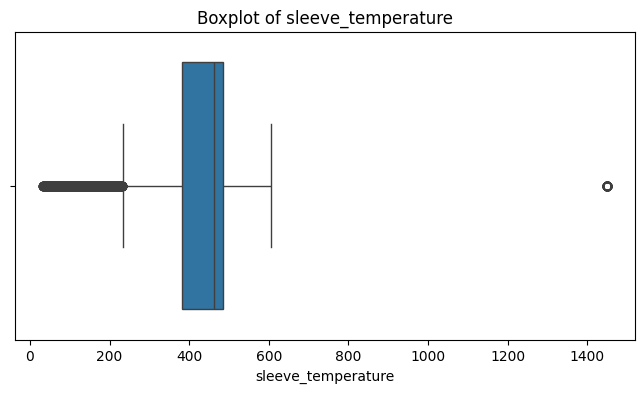

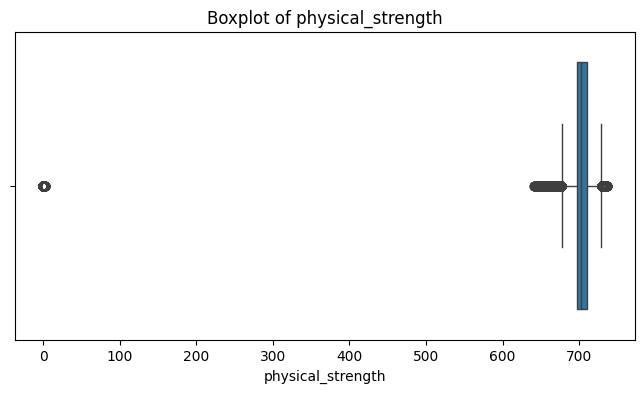

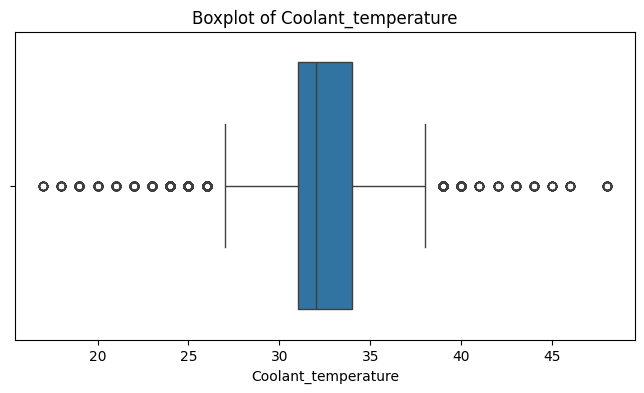

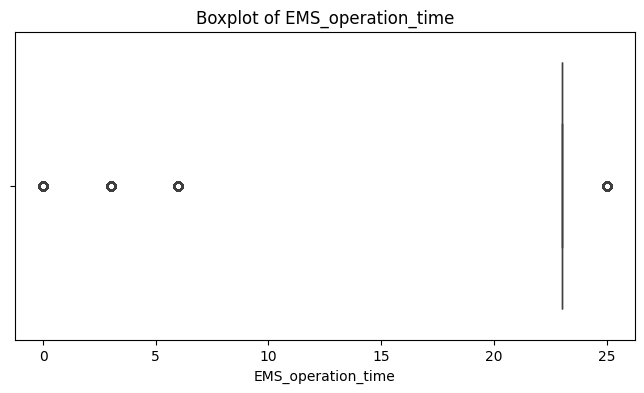

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['molten_temp','facility_operation_cycleTime',
       'production_cycletime', 'low_section_speed', 'high_section_speed',
       'cast_pressure', 'biscuit_thickness', 'upper_mold_temp1',
       'upper_mold_temp2', 'upper_mold_temp3', 'lower_mold_temp1',
       'lower_mold_temp2', 'lower_mold_temp3', 'sleeve_temperature',
       'physical_strength', 'Coolant_temperature', 'EMS_operation_time', ]

# 데이터프레임이 df라고 가정
for column in columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_no_outliers, x=column)
    plt.title(f'Boxplot of {column}')
    plt.show()

- T-test
    - T-test는 양품과 불량데이터간 차이가 유의미한 변수를 확인하는 것
    - 각 변수별로
        - ‘양품 집단과 불량 집단의 평균 차이가 없다’를 귀무가설
        - ‘양품 집단과 불량 집단의 평균 차이가 있다’를 대립가설
    - 일반적으로 pvalue 값이 0.05(or 0.1) 미만인 경우 귀무가설을 기각하고 대립가설을 채택

In [22]:
num_df = df_no_outliers
t_test = []
for i, col in enumerate(num_df.columns):
 t=scipy.stats.ttest_ind(num_df[num_df['passorfail']==1][col], num_df[num_df['passorfail']==0][col],
equal_var=False)
 t_test.append([col, t[0], t[1]])
df_ttest = pd.DataFrame(t_test, columns=['col', 'tvalue', 'pvalue'])
use_t_list = []
for i in range(len(df_ttest)):
 if df_ttest['pvalue'][i] < 0.05:
    use_t_list.append(df_ttest['col'][i])

print(f'p-값이 0.05보다 큰 값은 : {23-len(use_t_list)}개 입니다.')
df_ttest


p-값이 0.05보다 큰 값은 : 3개 입니다.


,col,tvalue,pvalue
0,count,-47.690793,0.000000e+00
1,working,-5.199011,2.115876e-07
2,molten_temp,1.934406,5.313583e-02
3,facility_operation_cycleTime,-0.806846,4.198061e-01
4,production_cycletime,-15.545979,7.813329e-53
5,low_section_speed,-22.148326,5.497622e-102
6,high_section_speed,9.401826,9.266487e-21
7,cast_pressure,-71.563698,0.000000e+00
8,biscuit_thickness,10.270377,2.085889e-24
9,upper_mold_temp1,-52.068600,0.000000e+00


In [23]:
# 이거는 p값이 0.05(0.1)이상인 컬럼은 영향이 없다고 판단하여 삭제하는건데
# 삭제하든 안하든 값은 큰 차이 없는 것으로 보임. (머신러닝 특성상 다 넣는게 좋을 수 있음)
num_df.drop(columns='molten_temp')
num_df.drop(columns='facility_operation_cycleTime')
num_df.drop(columns='upper_mold_temp3')

num_df

,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,...,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,243,1,720.0,98,125,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,0,0,1
1,244,1,721.0,98,122,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,0,0,1
2,245,1,721.0,100,125,112.0,109.0,308.0,49.0,268.0,...,179.0,1449.0,483.0,0.0,30.0,25,0.0,0,0,1
3,246,1,721.0,99,123,109.0,110.0,309.0,49.0,276.0,...,187.0,1449.0,486.0,0.0,30.0,25,0.0,0,0,1
4,247,1,722.0,100,125,110.0,110.0,308.0,50.0,279.0,...,195.0,1449.0,485.0,0.0,30.0,25,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90812,71,1,731.0,122,122,100.0,101.0,331.0,49.0,83.0,...,201.0,1449.0,279.0,726.0,30.0,0,0.0,0,6,0
90813,72,1,731.0,120,121,100.0,101.0,331.0,54.0,83.0,...,201.0,1449.0,279.0,732.0,30.0,0,0.0,0,6,0
90814,73,1,732.0,122,135,100.0,101.0,331.0,52.0,79.0,...,195.0,1449.0,272.0,731.0,30.0,0,0.0,0,6,0
90815,74,1,732.0,133,122,100.0,101.0,331.0,53.0,82.0,...,199.0,1449.0,288.0,723.0,30.0,0,0.0,0,6,0


In [24]:
num_pass = len(num_df[num_df['passorfail']==0])
num_fail = len(num_df[num_df['passorfail']==1])

print(f'pass : {num_pass}')
print(f'fail : {num_fail}')
print(f'불량률 : {num_fail/(num_pass+num_fail)*100} %')

pass : 87243
fail : 3574
불량률 : 3.935386546571677 %


In [25]:
# passorfail 맨 뒤로 보내기
df_done = num_df.drop(columns='passorfail')
df_done['passorfail'] = num_df['passorfail']
df_done

,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,...,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,tryshot_signal,mold_code,heating_furnace,passorfail
0,243,1,720.0,98,125,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0,0,1,0.0
1,244,1,721.0,98,122,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0,0,1,0.0
2,245,1,721.0,100,125,112.0,109.0,308.0,49.0,268.0,...,179.0,1449.0,483.0,0.0,30.0,25,0,0,1,0.0
3,246,1,721.0,99,123,109.0,110.0,309.0,49.0,276.0,...,187.0,1449.0,486.0,0.0,30.0,25,0,0,1,0.0
4,247,1,722.0,100,125,110.0,110.0,308.0,50.0,279.0,...,195.0,1449.0,485.0,0.0,30.0,25,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90812,71,1,731.0,122,122,100.0,101.0,331.0,49.0,83.0,...,201.0,1449.0,279.0,726.0,30.0,0,0,6,0,0.0
90813,72,1,731.0,120,121,100.0,101.0,331.0,54.0,83.0,...,201.0,1449.0,279.0,732.0,30.0,0,0,6,0,0.0
90814,73,1,732.0,122,135,100.0,101.0,331.0,52.0,79.0,...,195.0,1449.0,272.0,731.0,30.0,0,0,6,0,0.0
90815,74,1,732.0,133,122,100.0,101.0,331.0,53.0,82.0,...,199.0,1449.0,288.0,723.0,30.0,0,0,6,0,0.0


In [26]:
# df_done.hist(figsize=(25,20))
# plt.show()

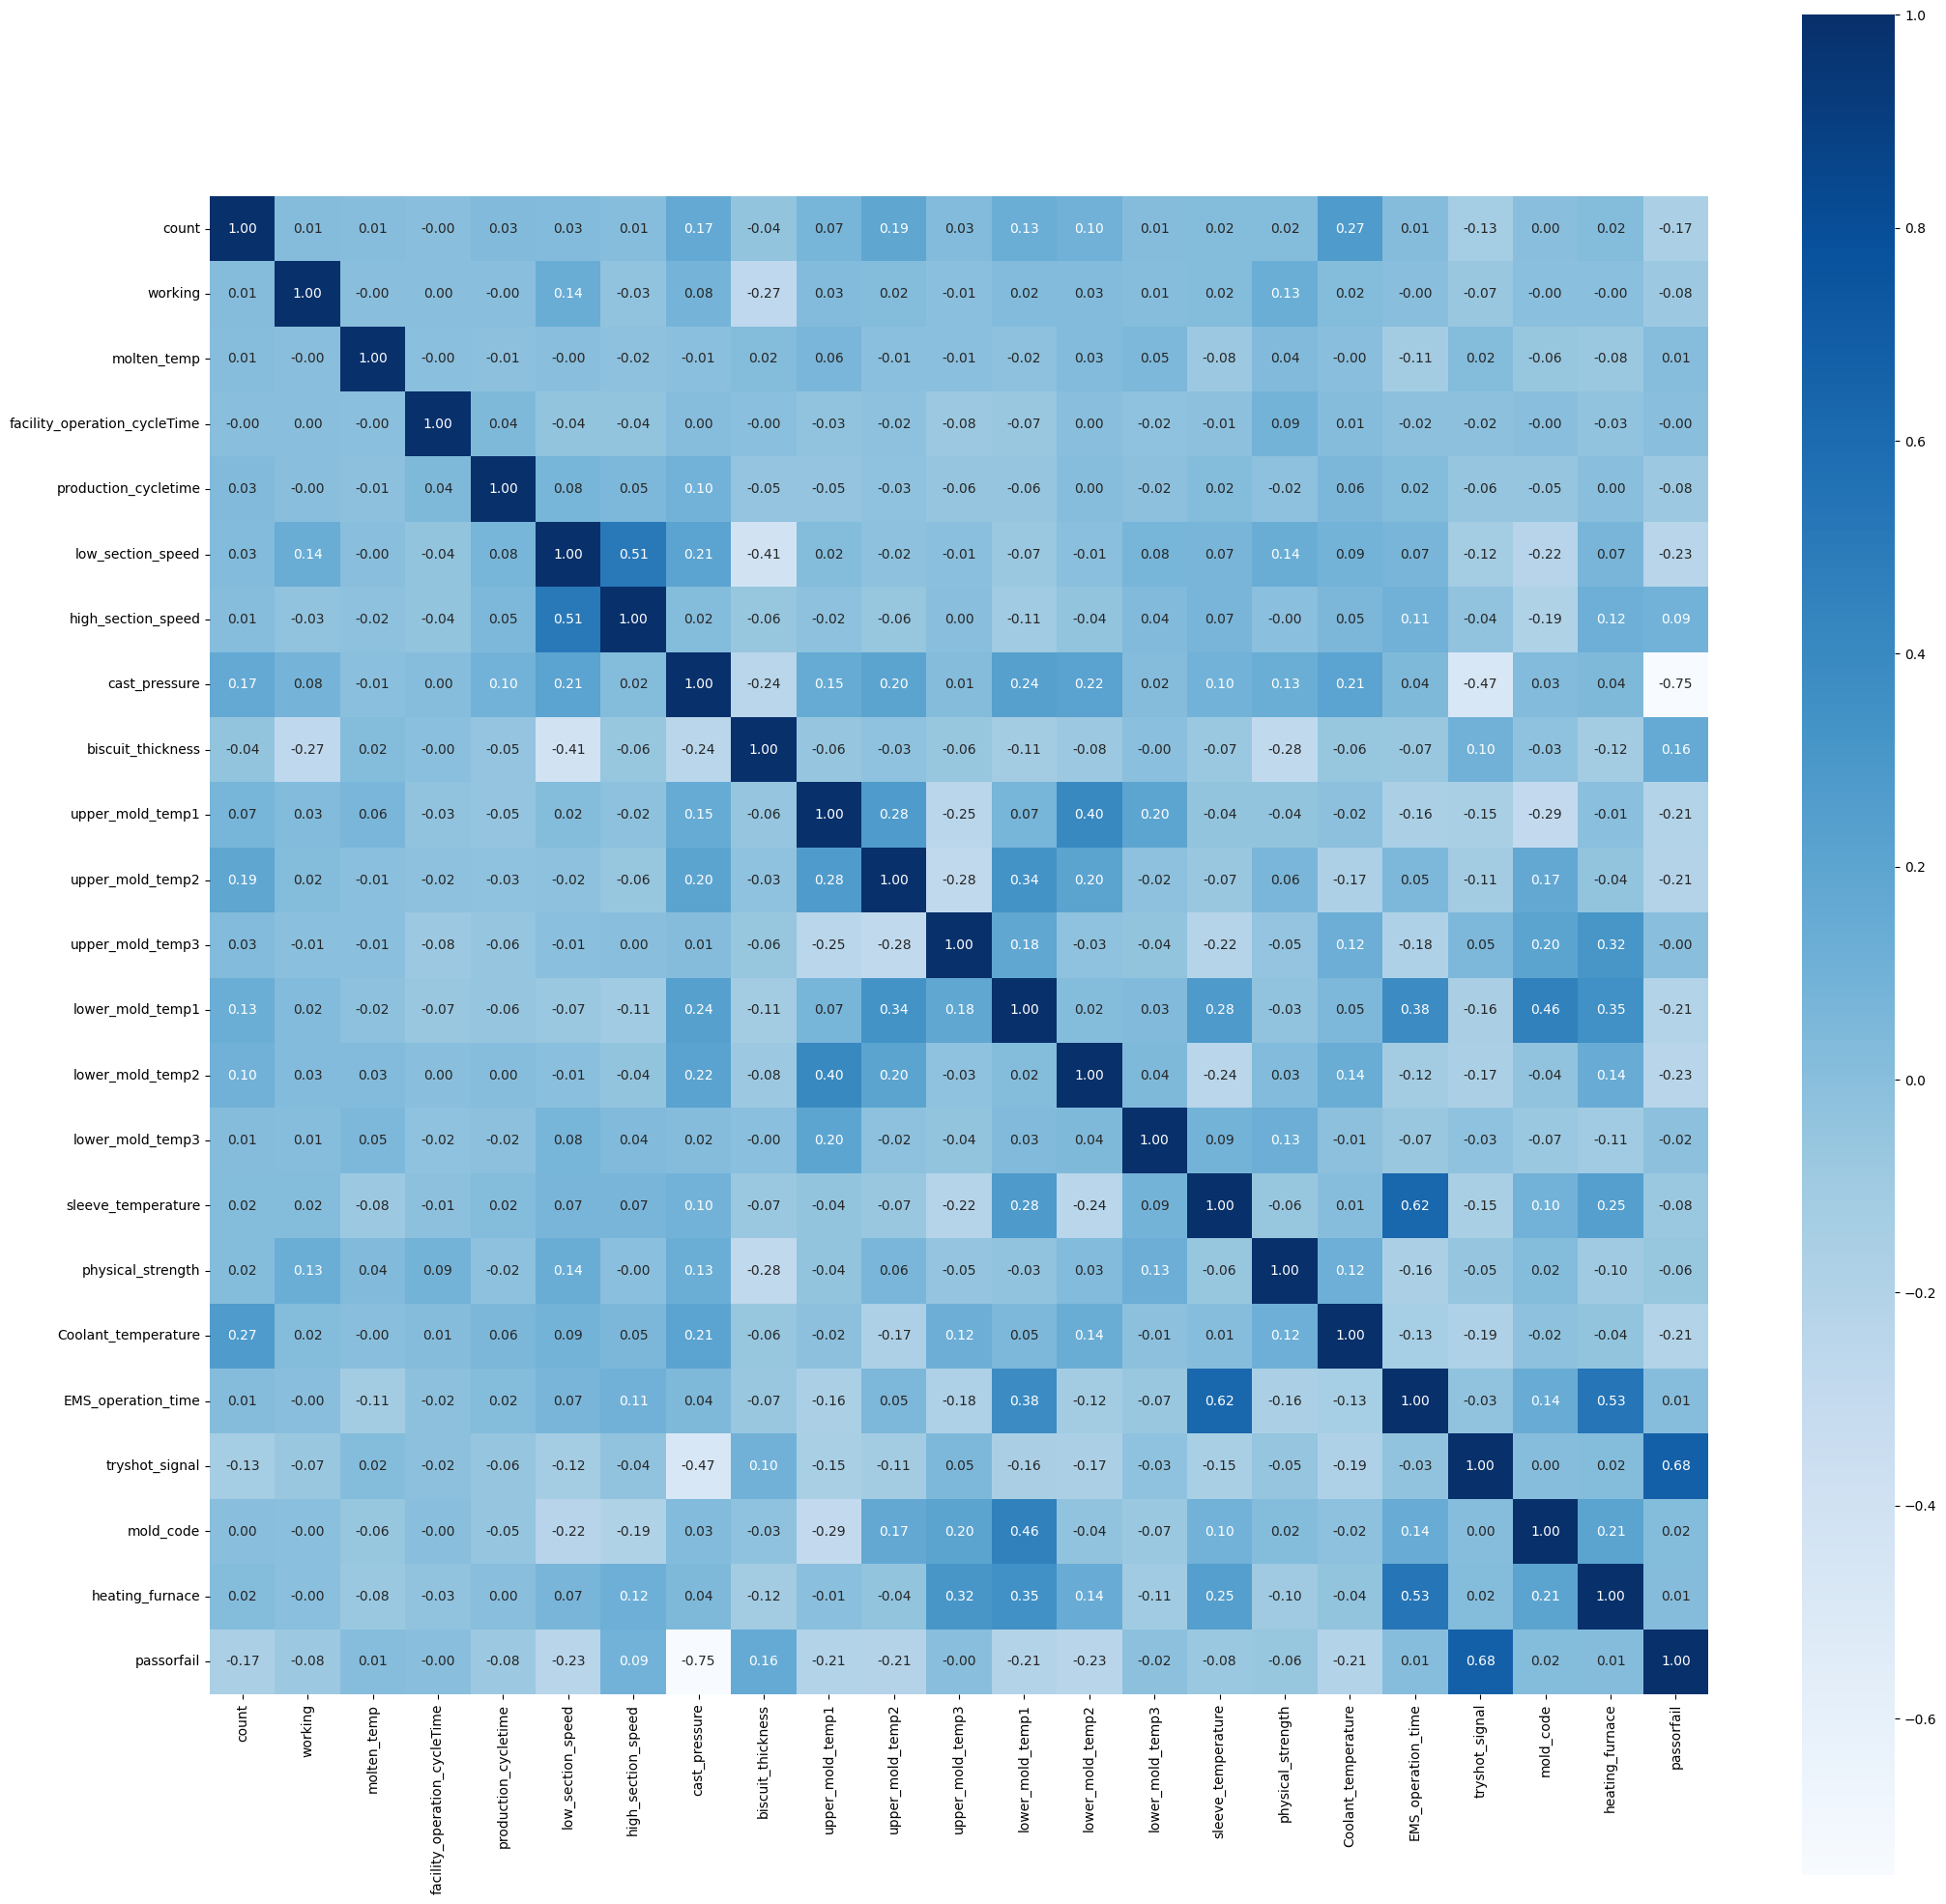

In [27]:
plt.figure(figsize=(25,25))
sns.heatmap(df_done.corr(), annot=True, fmt='.2f', square=True, cmap='Blues')
plt.show()

상관도 확인
- high_section_speed와 low_section_speed는 0.51로 높은 양의 상관관계를 보인다.
- passorfail과 cast_pressure의 상관계수는 -0.75로 매우 높은 음의 상관관계를 보이며
- sleeve_temperature과 EMS_operation_time은 0.63으로 높은 양의 상관관계를 보인다.
- EMS_operation_time와 heating_furnace는 0.53으로 높은 양의 상관관계를 보인다.
- tryshot_signal과 passorfail은 0.68로 매우 높은 양의 상관관계를 보인다



# 여기가지가 전처리 끝!



- 알고리즘 선택

In [32]:
import pandas as pd
from sklearn.utils import resample

# passorfail이 1인 데이터 분리
df_fail = df_done[df_done['passorfail'] == 1]

# passorfail이 0인 데이터 가져오기
df_pass = df_done[df_done['passorfail'] == 0]

# 다운샘플링할 비율 설정 (여기서는 패스 데이터 수의 절반으로 설정)
n_pass_samples = len(df_pass) // 2

# 패스 데이터에서 n_pass_samples 개수만큼 샘플링 => 즉, 절반을 샘플링
df_pass_downsampled = resample(df_pass,
                                replace=False,     # 샘플링 시복원 여부(중복방지)
                                n_samples=n_pass_samples,  # 샘플 수
                                random_state=42)  # 재현성 확보를 위한 랜덤 시드

# 선택되지 않은 패스 데이터 (다운샘플링에 선택되지 않은 데이터 - test에 사용)
df_pass_remaining = df_pass.drop(df_pass_downsampled.index)

# 새로운 데이터프레임 생성: pass 데이터와 다운샘플링된 fail 데이터 합치기
df_balanced = pd.concat([df_fail, df_pass_downsampled])

# 인덱스를 리셋하고 기존 인덱스를 삭제
df_balanced = df_balanced.reset_index(drop=True)

# 결과 출력
print(len(df_pass))
print(len(df_fail))
print(len(df_pass_downsampled))  # 다운샘플링 데이터 - train용
print(len(df_pass_remaining))  # 다운샘플링에 선택되지 않은 데이터 - test용
print(len(df_balanced))  # 다운샘플링 데이터 + fail 데이터

87243
3574
43621
43622
47195


In [58]:
df_pass_remaining.shape # 다운샘플링하고 남은 pass 데이터 (절반)

(43622, 23)

In [59]:
# 두 데이터프레임 비교 (잘 나눠졌는지 확인)
is_equal_df1_df2 = df_pass_downsampled.equals(df_pass_remaining)
print(f"df_pass_downsampled와 df_pass_remaining의 일치 여부: {is_equal_df1_df2}")

print(df_balanced['passorfail'].unique()) # df_balanced 확인

df_pass_downsampled와 df_pass_remaining의 일치 여부: False
[1. 0.]


In [35]:
# 데이터 분할
X = df_balanced.drop('passorfail', axis=1).values
y = df_balanced['passorfail'].values

# 다운샘플링에서 잘라낸 데이터를 X_test에 합쳐주기 위해서 X1, y1으로 분리
X1 = df_pass_remaining.drop('passorfail', axis=1).values
y1 = df_pass_remaining['passorfail'].values

X.shape, y.shape, X1.shape, y1.shape

((47195, 22), (47195,), (43622, 22), (43622,))

In [66]:
# 불량률이 3%에 불과한 데이터에 대해 분할 split마다 양품과 불량이 균등한 비율로 구성되도록 StratifiedShuffleSplit을 적용
sss = StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2)

In [67]:
# 0~1사이로 정규화
# 데이터 정규화를 하는 이유는 각 변수별로 값의 범위가 다르게 되면
# 모델은 크기가 큰 변수에 영향을 많이 받게 되어 부정확한 모델이 생성
mms = MinMaxScaler()

In [68]:
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42, eval_metric='error', use_label_encoder=False)
lgbm_clf = LGBMClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

In [76]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# 수직으로 합치기
X_test = np.concatenate((X_test, X1), axis=0)
y_test = np.concatenate((y_test, y1), axis=0)

# 합쳐졌는지 확인하기 : 9445 + 43634 = 53079
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37756, 22), (53061, 22), (37756,), (53061,))

In [78]:
# 1의 데이터 수 확인 => 2872개는 80%이다.
count_of_ones = (y_train == 1).sum()
print("Number of 1s in y_train:", count_of_ones)

Number of 1s in y_train: 2859


In [79]:
# 원본 데이터를 DataFrame으로 변환하여 저장
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)

# 소수 클래스의 샘플 수를 다수 클래스의 수와 맞추기 위한 SMOTE
# fail 비율을 0.15로 하여 2364개의 데이터가 생성. 기존 데이터 2872보다 크지않게 설정함.
smote = SMOTE(sampling_strategy=0.15, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_df, y_train_df)

count_of_zeros = (y_resampled == 0).sum()
count_of_ones = (y_resampled == 1).sum()
print("Number of 0s in y_train:", count_of_zeros)
print("Number of 1s in y_train:", count_of_ones)

Number of 0s in y_train: 34897
Number of 1s in y_train: 5234


In [80]:
# 테스트, 트레인 데이터의 비율 확인하기.

num_pass = len(y_resampled[y_resampled == 0])
num_fail = len(y_resampled[y_resampled == 1])

print(f'pass : {num_pass}')
print(f'fail : {num_fail}')
print(f'y_test의 불량률 : {num_fail/(num_pass+num_fail)*100} %')

num_pass = len(y_test[y_test == 0])
num_fail = len(y_test[y_test == 1])

print(f'pass : {num_pass}')
print(f'fail : {num_fail}')
print(f'y_test의 불량률 : {num_fail/(num_pass+num_fail)*100} %')

pass : 34897
fail : 5234
y_test의 불량률 : 13.042286511674266 %
pass : 52346
fail : 715
y_test의 불량률 : 1.347505700985658 %


# LGBMClassifier

In [81]:
# 데이터 스케일링
mms = MinMaxScaler()
X_train_scaled = mms.fit_transform(X_resampled)
X_test_scaled = mms.transform(X_test)

# 랜덤 서치 설정
from sklearn.model_selection import RandomizedSearchCV
distributions = {
    'num_leaves': np.arange(20, 150, 1),
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.05, 0.1, 0.2, 1],
    'n_estimators': np.arange(10, 100, 1)
}

random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=distributions,
    scoring='f1',
    n_iter=1000,
    cv=5,
    n_jobs=-1,
    random_state=42
)

# 학습
random_search.fit(X_train_scaled, y_resampled)

[LightGBM] [Info] Number of positive: 5234, number of negative: 34897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4589
[LightGBM] [Info] Number of data points in the train set: 40131, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130423 -> initscore=-1.897225
[LightGBM] [Info] Start training from score -1.897225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 1],
                                        'max_depth': [-1, 10, 20, 30],
                                        'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 6...
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])},
                   random_state=42, scoring='f1')

In [82]:
# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'num_leaves': 98, 'n_estimators': 90, 'max_depth': 20, 'learning_rate': 0.2}


Best parameters found:  {'num_leaves': 98, 'n_estimators': 90, 'max_depth': 20, 'learning_rate': 0.2}

In [83]:
# Update your model with the best parameters
lgbm_clf = LGBMClassifier(**best_params, random_state=42)

# Re-run your cross-validation with the best parameters
lgbm_fold_f1 = []
n_iter = 0
idx_list = []

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]
        X_train_scaled = mms.fit_transform(X_train)
        X_test_scaled = mms.transform(X_test)
        X_valid_scaled = mms.transform(X_valid)

        lgbm_clf.fit(X_train_scaled, y_train)
        valid_pred = lgbm_clf.predict(X_valid_scaled)
        test_pred = lgbm_clf.predict(X_test_scaled)

        valid_f1 = f1_score(y_valid, valid_pred)
        test_f1 = f1_score(y_test, test_pred)

        valid_CR = classification_report(y_valid, valid_pred)
        test_CR = classification_report(y_test, test_pred)

        n_iter += 1
        lgbm_fold_f1.append([n_iter, test_f1])
        idx_list.append([train_idx, test_idx])

    print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_CR}')
    print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_CR}')
    print('='*50)

lgbm_fold_f1.sort(key=lambda x: x[1], reverse=True)
print(f'교차검증 중 가장 높은 정확도 : Split {lgbm_fold_f1[0][0]} {lgbm_fold_f1[0][1]}')


[LightGBM] [Info] Number of positive: 2859, number of negative: 34897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 37756, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075723 -> initscore=-2.501929
[LightGBM] [Info] Start training from score -2.501929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Info] Number of positive: 2861, number of negative: 27343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2422
[LightGBM] [Info] Number of data points in the train set: 30204, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.094723 -> initscore=-2.257289
[LightGBM] [Info] Start training from score -2.257289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

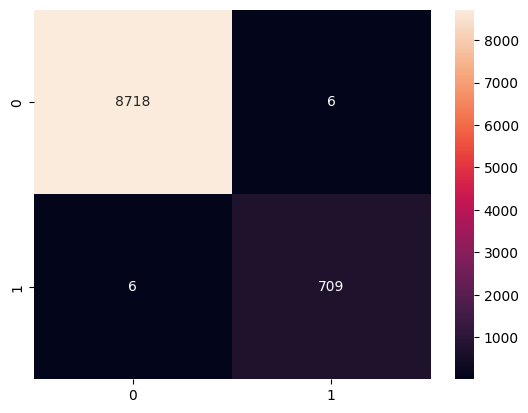

In [84]:
lgbm_clf.fit(X[idx_list[lgbm_fold_f1[0][0]-1][0]], y[idx_list[lgbm_fold_f1[0][0]-1][0]])
pred = lgbm_clf.predict(X[idx_list[lgbm_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

# XGBClassifier

In [ ]:
# 데이터 스케일링
mms = MinMaxScaler()
X_train_scaled = mms.fit_transform(X_resampled)
X_test_scaled = mms.transform(X_test)

# 랜덤 서치 설정
from sklearn.model_selection import RandomizedSearchCV
distributions = {
    'num_leaves': np.arange(20, 150, 1),
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.05, 0.1, 0.2, 1],
    'n_estimators': np.arange(10, 100, 1)
}

random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=distributions,
    scoring='f1',
    n_iter=1000,
    cv=5,
    n_jobs=-1,
    random_state=42
)

# 학습
random_search.fit(X_train_scaled, y_resampled)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

In [ ]:

# Update your model with the best parameters
lgbm_clf = XGBClassifier(**best_params, random_state=42)

# Re-run your cross-validation with the best parameters
lgbm_fold_f1 = []
n_iter = 0
idx_list = []

lgbm_fold_f1.sort(key=lambda x: x[1], reverse=True)

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, y_train = smote.fit_resample(X_train, y_train)

    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]
        X_train_scaled = mms.fit_transform(X_train)
        X_test_scaled = mms.transform(X_test)
        X_valid_scaled = mms.transform(X_valid)

        lgbm_clf.fit(X_train_scaled, y_train)
        valid_pred = lgbm_clf.predict(X_valid_scaled)
        test_pred = lgbm_clf.predict(X_test_scaled)

        valid_f1 = f1_score(y_valid, valid_pred)
        test_f1 = f1_score(y_test, test_pred)

        valid_CR = classification_report(y_valid, valid_pred)
        test_CR = classification_report(y_test, test_pred)

        n_iter += 1
        lgbm_fold_f1.append([n_iter, test_f1])
        idx_list.append([train_idx, test_idx])

    print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_CR}')
    print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_CR}')
    print('='*50)

lgbm_fold_f1.sort(key=lambda x: x[1], reverse=True)
print(f'교차검증 중 가장 높은 정확도 : Split {lgbm_fold_f1[0][0]} {lgbm_fold_f1[0][1]}')

lgbm_clf.fit(X[idx_list[lgbm_fold_f1[0][0]-1][0]], y[idx_list[lgbm_fold_f1[0][0]-1][0]])
pred = lgbm_clf.predict(X[idx_list[lgbm_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()